<a href="https://colab.research.google.com/github/Vaggelis-Arg/Amazon-Ecommerce-Analysis/blob/main/Amazon_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining (2024-2025)

## Team Information

#### Team member #1: [**Vaggelis-Arg**](https://github.com/Vaggelis-Arg)
* Ονοματεπώνυμο: Βαγγέλης Αργυρόπουλος
* Αριθμός Μητρώου: sdi2200010
* email: sdi2200010@di.uoa.gr
---
#### Team member #2: [**chrisvl11**](https://github.com/chrisvl11)
* Ονοματεπώνυμο: Χρήστος Βλαδίκας
* Αριθμός Μητρώου: sdi2200020
* email: sdi2200020@di.uoa.gr
---
#### Team member #3: [**tonykalantzis**](https://github.com/tonykalantzis)
* Ονοματεπώνυμο: Αντώνιος Παναγιώτης Καλαντζής
* Αριθμός Μητρώου: sdi2100046
* email: sdi2100046@di.uoa.gr
---

## Set up of the notebook

### Downloads

In [1]:
!pip install nltk
!pip install datasets
!pip install contractions
!pip install matplotlib seaborn wordcloud
!pip install nltk transformers torch


### Imports

In [2]:
import nltk
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'wordnet'])
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
import pandas as pd
import re
import string
import contractions
from datasets import load_dataset
from matplotlib.gridspec import GridSpec
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline


[nltk_data] Downloading package punkt to /home/tony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tony/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/tony/Code/DIT/YS11-Data-Extraction-Techniques/Amazon-Ecommerce-Analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1 - Pre-processing

### Task 1: Data Exploration and Feature Engineering

#### Dataset Preparation

We used the `datasets` library from Hugging Face to stream and extract reviews and metadata for selected Amazon product categories. For demonstration, we focused on the "All_Beauty" category.

The dataset includes product reviews, ratings, and associated metadata. After loading, the data was saved as CSV files (`*_reviews_raw.csv` and `*_metadata_raw.csv`) to simplify further processing.

We ensure the CSVs contain essential fields like `rating`, `text`, `parent_asin`, and product details for later analysis.



In [ ]:
# Configs: (category_name, review_config, meta_config)
datasets_info = [
    ("Books", "raw_review_Books", "raw_meta_Books"),
    ("All_Beauty", "raw_review_All_Beauty", "raw_meta_All_Beauty"),
    ("Electronics", "raw_review_Electronics", "raw_meta_Electronics"),
    ("Movies_and_TV", "raw_review_Movies_and_TV", "raw_meta_Movies_and_TV"),
    ("Sports_and_Outdoors", "raw_review_Sports_and_Outdoors", "raw_meta_Sports_and_Outdoors"),
]
    
# Select correct columns 
review_columns = [
    "rating", "title", "text", "parent_asin", "user_id", "timestamp", 
    "helpful_vote", "verified_purchase"
]
meta_columns = [
    "parent_asin", "main_category", "title", "average_rating", "rating_number",
    "description", "price", "categories", "bought_together", "store"
]

for category, review_config, metadata_config in datasets_info:
    print(f"Loading: {category}")

    # Load streaming datasets with limited columns
    reviews_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        review_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(review_columns)

    metadata_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        metadata_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(meta_columns)

    # Convert to pandas and save
    reviews_df = pd.DataFrame(reviews_iter.take(200_000))
    metadata_df = pd.DataFrame(metadata_iter.take(200_000))

    reviews_df.to_csv(f"{category}_reviews_selected.csv", index=False)
    metadata_df.to_csv(f"{category}_metadata_selected.csv", index=False)

    print(f"Saved selected columns for {category}")
    

#### Text Preprocessing

Text fields like `title` and `review text` were cleaned using a custom preprocessing function that includes:

- Lowercasing
- URL, mention, hashtag, and email removal
- Contraction expansion (`don't` → `do not`)
- Emoticon normalization (e.g., `:)` → `happy`)
- Removal of punctuation, numbers, and excessive character repetitions

These cleaned fields (`cleaned_title`, `cleaned_text`) are used for visualizations and later analysis tasks.


In [10]:
# Emoticon dictionary for replacements
emoticons = {
    ":)": "happy",
    ":-)": "happy",
    ":(": "sad",
    ":-(": "sad",
    ":D": "happy",
    ":-D": "happy",
    ";)": "wink",
    ";-)": "wink"
}

def normalize_price(price, min_price, max_price):
    return (price - min_price) / (max_price - min_price) if max_price != min_price else 0

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"\S+@\S+", '', text)  # remove emails
    text = contractions.fix(text)  # expand contractions

    # Replace emoticons
    for emoticon, word in emoticons.items():
        text = text.replace(emoticon, word)

    text = re.sub(r"[" + string.punctuation + "]", '', text)  # remove punctuation
    text = re.sub(r"\d+", '', text)  # remove numbers
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # reduce 3+ char repeats to 2

    text = text.strip()
    return text

# Load and clean each dataset
for category, *_ in datasets_info:
    print(f"Processing: {category}")
    reviews = pd.read_csv(f"{category}_reviews_selected.csv")
    metadata = pd.read_csv(f"{category}_metadata_selected.csv")

    reviews = reviews.dropna(subset=["rating", "text", "parent_asin"])
    reviews["cleaned_title"] = reviews["title"].apply(preprocess_text)
    reviews["cleaned_text"] = reviews["text"].apply(preprocess_text)
    reviews["timestamp"] = pd.to_datetime(reviews["timestamp"], unit="ms")

    df = pd.merge(reviews, metadata, on="parent_asin", how="left", suffixes=("", "_meta"))
    
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        
        # Remove any rows where price is NaN
        df = df.dropna(subset=['price'])
        
        min_price = df['price'].min()
        max_price = df['price'].max()
        df['normalized_price'] = df['price'].apply(lambda x: normalize_price(x, min_price, max_price))
        
    df.to_csv(f"{category}_cleaned.csv", index=False)
    print(f"Saved cleaned data to {category}_cleaned.csv")

print(reviews.head())

NameError: name 'datasets_info' is not defined

#### Ratings and Reviews

##### 1. Rating Distribution

A histogram with kernel density estimation (KDE) was plotted to show how product ratings are distributed across all reviews in each category.

##### 2. Low-Rated Popular Products – Word Cloud

We identified products with an average rating below 3 and a sufficient number of reviews, then generated a word cloud from their review texts to highlight frequently used negative terms.

##### 3. Rating Trends Over Time

We computed the average rating per month and plotted a line chart to observe how customer sentiment evolves over time. This helps detect seasonality or significant shifts in perception.

##### 4. Top 5 Best-Selling Products

We listed the five most-reviewed products in each category, including:
- Title
- ASIN
- Store (if available)
- Average rating
- Total number of reviews

These summaries provide a snapshot of the most impactful products per category.



Visualizing: Books


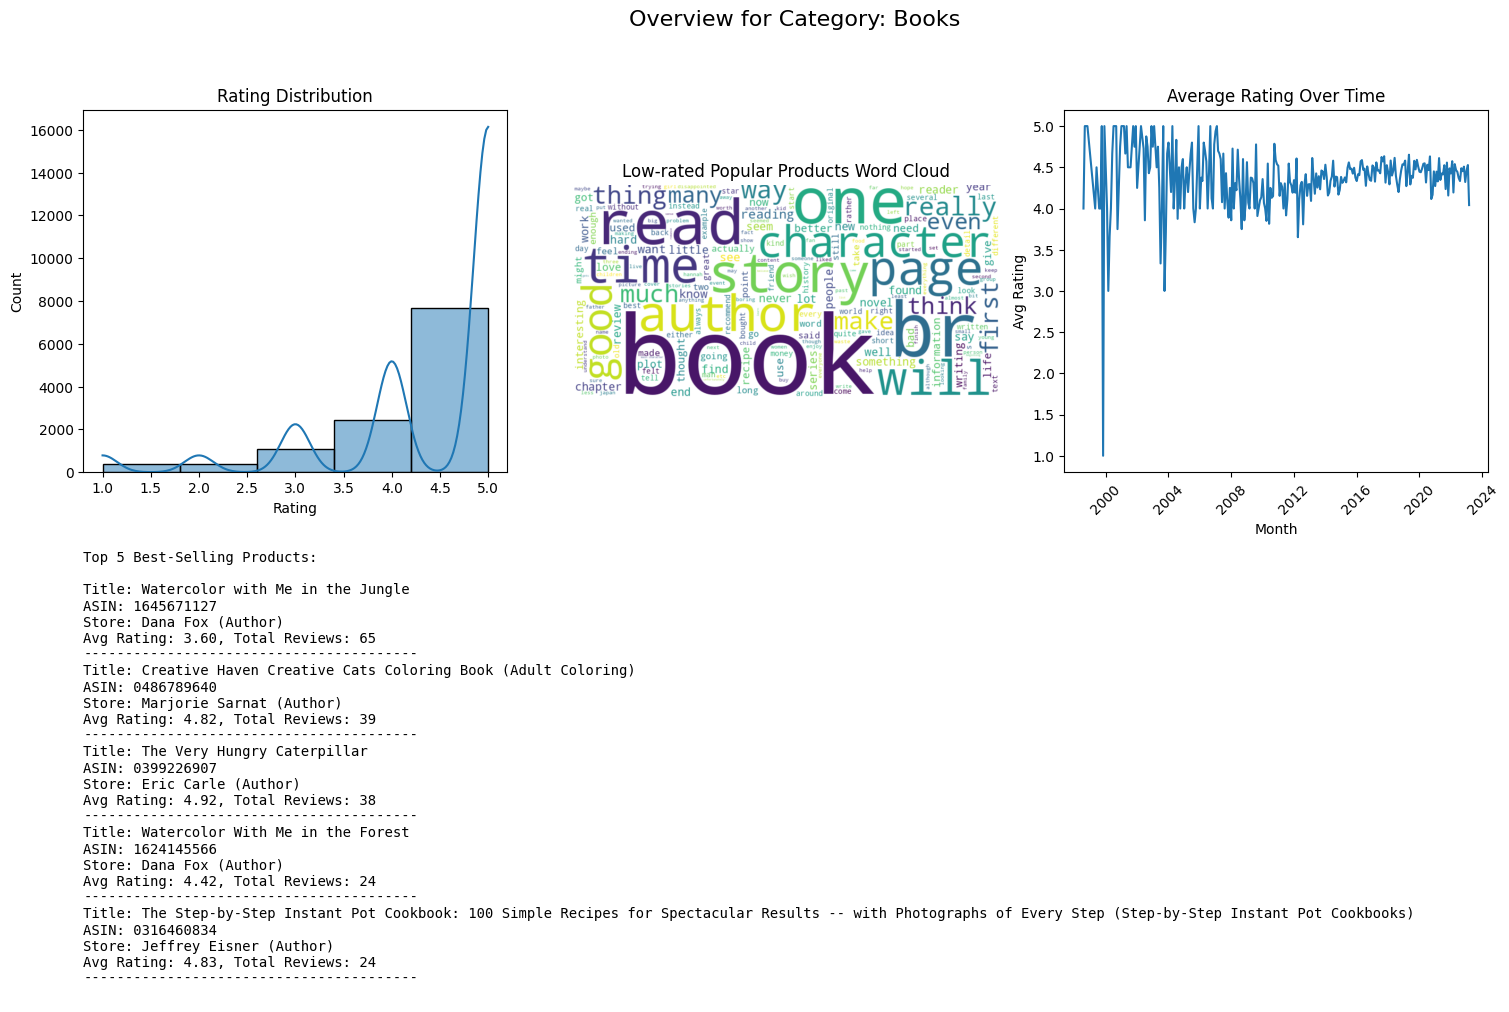

Visualizing: All_Beauty


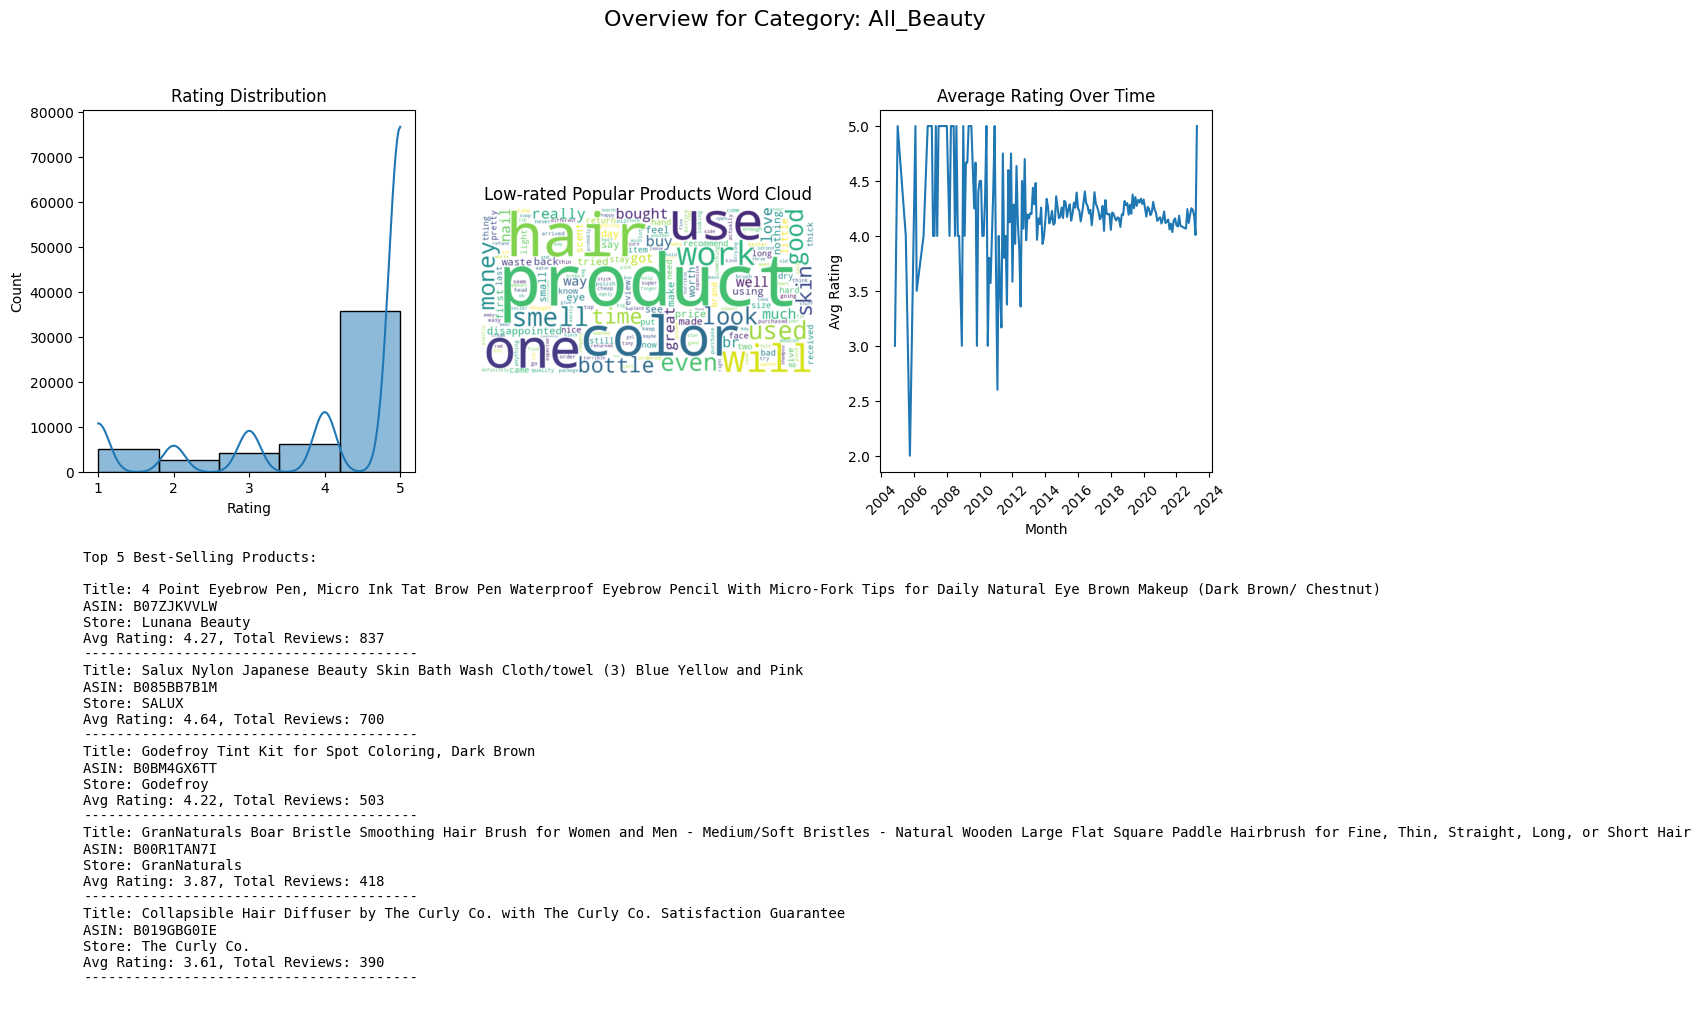

Visualizing: Electronics


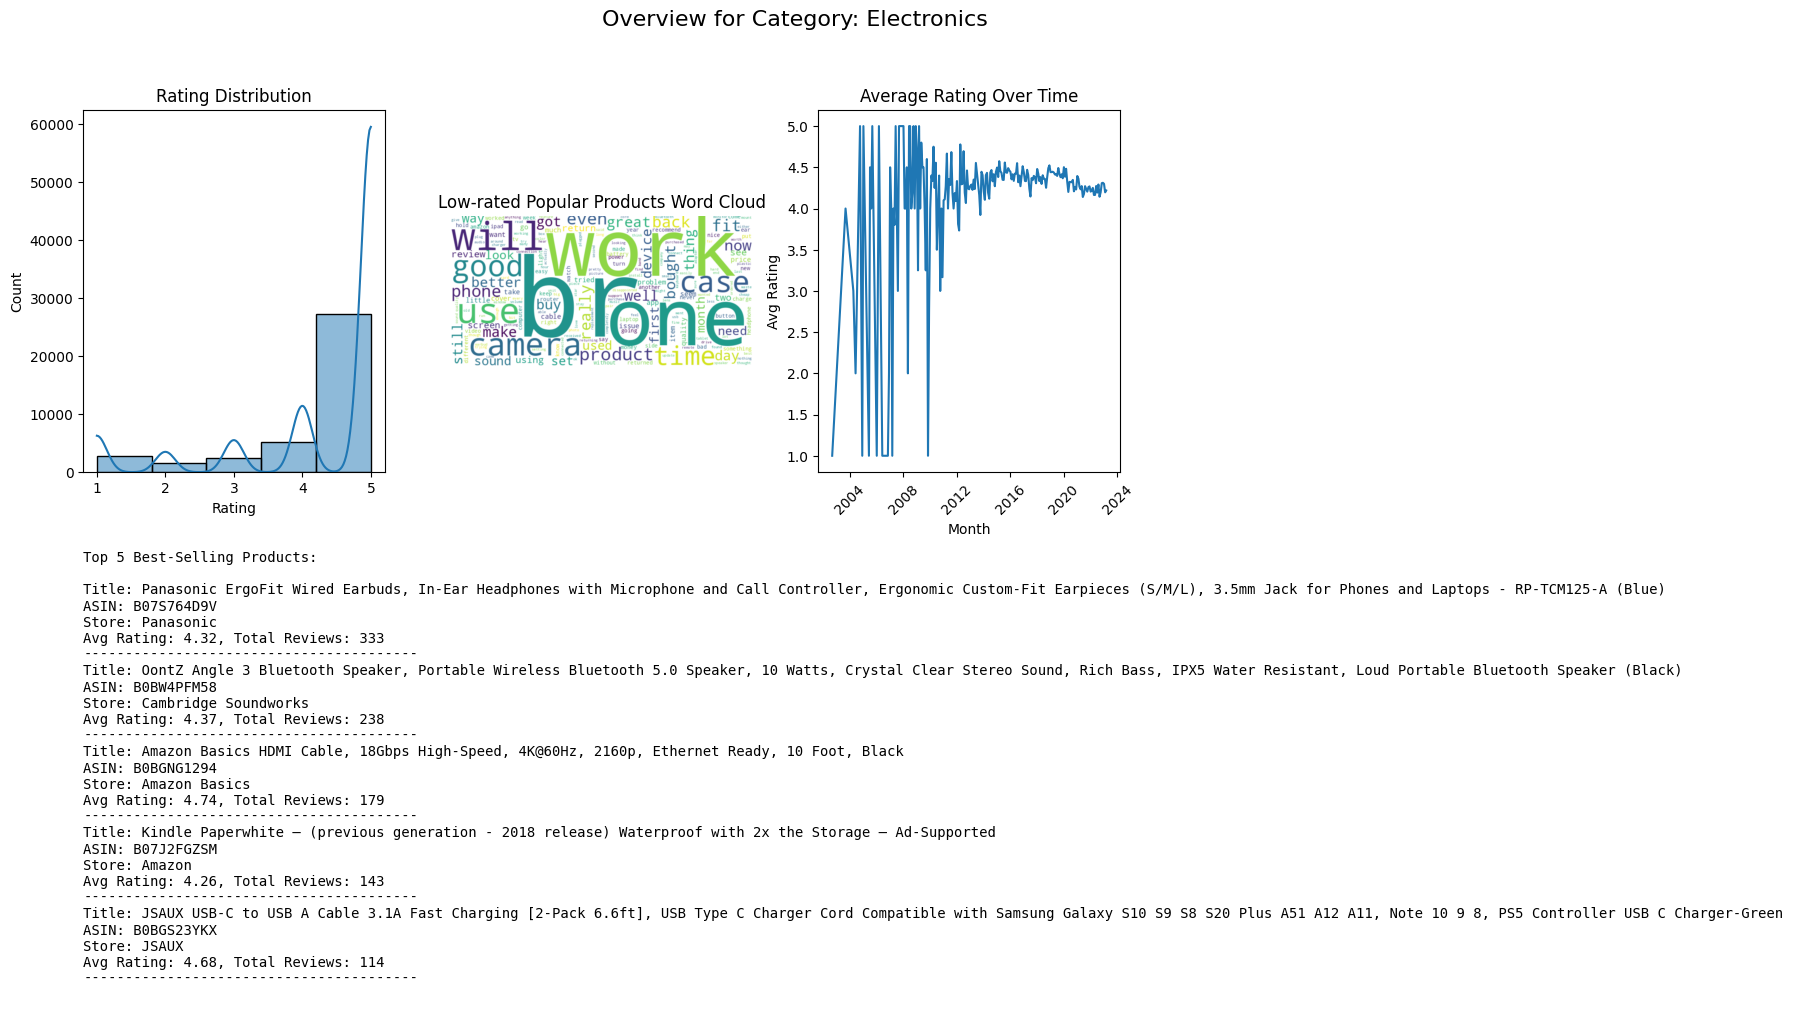

Visualizing: Movies_and_TV


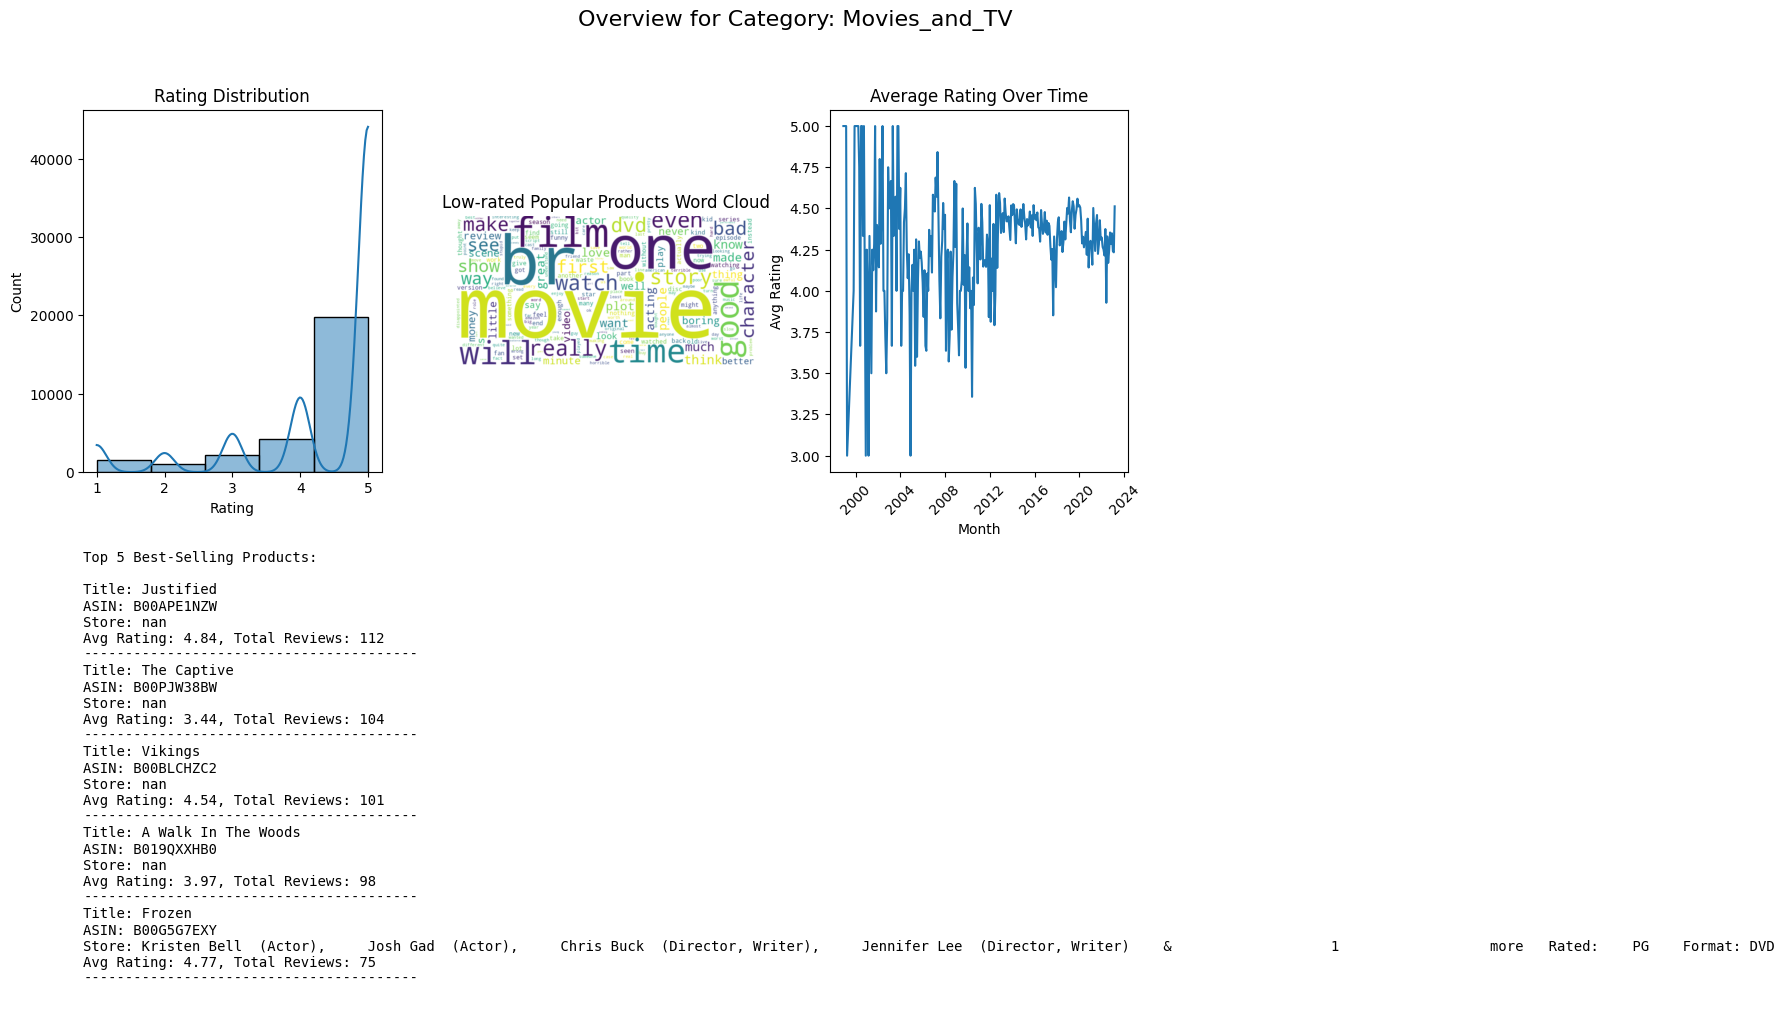

Visualizing: Sports_and_Outdoors


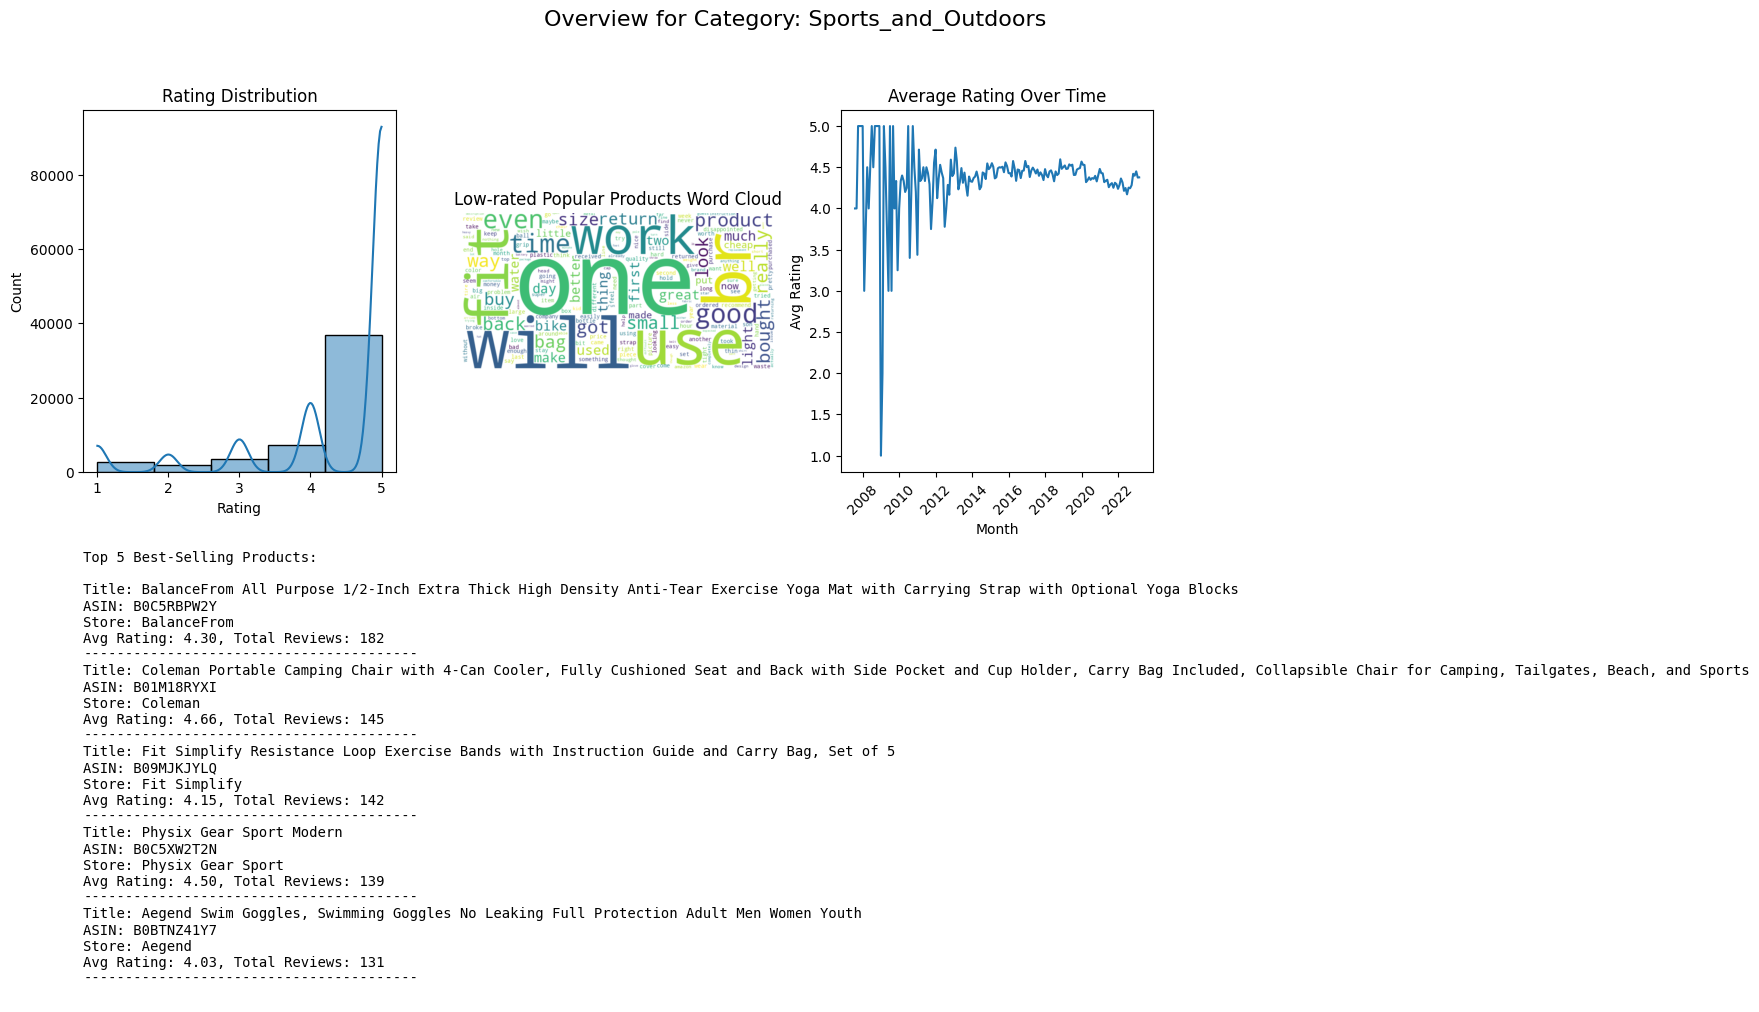

In [ ]:
for category, *_ in datasets_info:
    print(f"Visualizing: {category}")
    df = pd.read_csv(f"{category}_cleaned.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["month"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()
    
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df = df.dropna(subset=["rating"])
    
    stats = df.groupby("parent_asin").agg(
        avg_rating=("rating", "mean"),
		count=("rating", "count")
	).reset_index()
    
    bad_asins = stats[
    	(stats["count"] >= 0) & (stats["avg_rating"] < 3)
	]["parent_asin"]
    
    bad_text = " ".join(df[df["parent_asin"].isin(bad_asins)]["cleaned_text"].dropna())
    wordcloud = None
    if bad_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(bad_text)

    # Prepare trend data
    trend = df.groupby("month")["rating"].mean().reset_index()

    # Prepare top products text
    top5 = df["parent_asin"].value_counts().head(5).index
    top_products_info = ""
    for asin in top5:
        item = df[df["parent_asin"] == asin].iloc[0]
        avg_rating = df[df["parent_asin"] == asin]["rating"].mean()
        total_reviews = len(df[df["parent_asin"] == asin])
        top_products_info += (
            f"Title: {item.get('title_meta', 'N/A')}\n"
            f"ASIN: {asin}\n"
            f"Store: {item.get('store', 'Unknown')}\n"
            f"Avg Rating: {avg_rating:.2f}, Total Reviews: {total_reviews}\n"
            f"{'-'*40}\n"
        )

    # Create subplots
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f"Overview for Category: {category}", fontsize=16, y=1.02)
    gs = GridSpec(2, 3, figure=fig)

    # Histogram
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df["rating"], bins=5, kde=True, ax=ax1)
    ax1.set_title("Rating Distribution")
    ax1.set_xlabel("Rating")
    ax1.set_ylabel("Count")

    # Word Cloud
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Low-rated Popular Products Word Cloud")
    if wordcloud:
        ax2.imshow(wordcloud, interpolation="bilinear")
        ax2.axis("off")
    else:
        ax2.text(0.5, 0.5, "No data for word cloud", ha='center', va='center', fontsize=12)
        ax2.axis("off")

    # Trend Line
    ax3 = fig.add_subplot(gs[0, 2])
    sns.lineplot(data=trend, x="month", y="rating", ax=ax3)
    ax3.set_title("Average Rating Over Time")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Avg Rating")
    ax3.tick_params(axis='x', rotation=45)

    # Text Box for Top Products
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis("off")
    ax4.text(0, 1, f"Top 5 Best-Selling Products:\n\n{top_products_info}", ha='left', va='top', fontsize=10, family='monospace')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


### Task 2: Feature Engineering with **Sentiment Scores** and Ratings

#### SentimentScoreWithRating Class

This class combines the **text sentiment** of a review with its **numeric rating (1–5)** to generate a more informative sentiment score.

---

#### 1. Sentiment Extraction

- Uses either **VADER** or a **Hugging Face model** (`DistilBERT`, `RoBERTa`, or `BERT`)
- Converts review text to a sentiment score in the range:

$$
\text{sentiment\_score} \in [-1, 1]
$$

---

#### 2. Weighted Sentiment + Rating

To balance sentiment from text and numeric rating:

$$
\text{final\_score} = w_1 \cdot \text{sentiment\_score} + w_2 \cdot \text{normalized\_rating}
$$

where:

$$
\text{normalized\_rating} = \frac{\text{rating} - 1}{4}
$$

Default weights: \( w_1 = 0.5 \), \( w_2 = 0.5 \)

---

#### 3. Rating-Adjusted Sentiment

Boost or reduce sentiment depending on how strong the rating is:

- Add adjustment (e.g. +0.2) if rating is 4 or 5  
- Subtract adjustment (e.g. -0.2) if rating is 1 or 2

This ensures the final score reflects both tone and user satisfaction.

---

In [3]:
class SentimentScoreWithRating:
    def __init__(self, method="vader"):
        """
        method: "vader" or one of ["distilbert", "roberta", "bert"]
        """
        self.method = method.lower()
        if self.method == "vader":
            self.analyzer = SentimentIntensityAnalyzer()
        elif self.method in ["distilbert", "roberta", "bert"]:
            model_map = {
                "distilbert": "distilbert-base-uncased-finetuned-sst-2-english",
                "roberta": "cardiffnlp/twitter-roberta-base-sentiment",
                "bert": "nlptown/bert-base-multilingual-uncased-sentiment"
            }
            self.analyzer = pipeline("sentiment-analysis", model=model_map[self.method])
        else:
            raise ValueError("Unsupported method")

    def extract_sentiment_score(self, text):
        """
        Returns a sentiment score in range [-1, +1]
        """
        if self.method == "vader":
            score = self.analyzer.polarity_scores(text)["compound"]
            return score
        else:
            result = self.analyzer(text[:512])[0]  # Truncate long reviews
            label = result["label"].lower()
            if "positive" in label:
                return 1.0
            elif "negative" in label:
                return -1.0
            else:
                return 0.0

    def normalize_rating(self, rating):
        """
        Normalize rating from 1-5 stars to 0-1
        """
        return (rating - 1) / 4

    def sentiment_score_weighted_text_rating(self, text, rating, w_text=0.5, w_rating=0.5):
        """
        Combine text sentiment and normalized rating via weighted average
        """
        sentiment = self.extract_sentiment_score(text)
        norm_rating = self.normalize_rating(rating)
        combined_score = w_text * sentiment + w_rating * norm_rating
        return combined_score

    def sentiment_score_rating_adjusted(self, text, rating, adjustment=0.2):
        """
        Adjust sentiment based on rating intensity
        """
        sentiment = self.extract_sentiment_score(text)

        # Adjust based on rating range
        if rating >= 4:
            sentiment = min(sentiment + adjustment, 1.0)
        elif rating <= 2:
            sentiment = max(sentiment - adjustment, -1.0)
        # If rating == 3 → no adjustment

        return sentiment


In [6]:
methods = ["vader", "distilbert", "roberta", "bert"]

text = "perfect awesome sexy all perfect"
rating = 2

for method in methods:
    print(f"\nTesting method: {method}")
    analyzer = SentimentScoreWithRating(method)
    
    adjusted = analyzer.sentiment_score_rating_adjusted(text, rating)
    weighted = analyzer.sentiment_score_weighted_text_rating(text, rating)
    
    print(f" - Adjusted: {adjusted:.3f}")
    print(f" - Weighted: {weighted:.3f}")



Testing method: vader
 - Adjusted: 0.742
 - Weighted: 0.596

Testing method: distilbert


Device set to use cpu


 - Adjusted: 0.800
 - Weighted: 0.625

Testing method: roberta


Device set to use cpu


 - Adjusted: -0.200
 - Weighted: 0.125

Testing method: bert


Device set to use cpu


 - Adjusted: -0.200
 - Weighted: 0.125


### Task 3: Feature Engineering with Price Metrics (Optional)

We created two new features to improve comparability between products:

---

#### 1. Weighted Rating  
To reduce the bias from products with few reviews, we used:

$$
\text{weighted\_rating} = \text{average\_rating} \times \log(\text{rating\_number} + 1)
$$

This boosts trust in ratings with more votes and penalizes small-sample anomalies.

---

#### 2. Price per Unit  
To compare products fairly across sizes (e.g., 500ml vs 250ml), we extracted quantities like `ml`, `g`, `oz`, and computed:

$$
\text{price\_per\_unit} = \frac{\text{price}}{\text{quantity}}
$$

If no quantity was found, we assumed `quantity = 1`.

This is useful for categories like **Beauty**, **Health**, and **Grocery**.

In [23]:
for category, *_ in datasets_info:
    print(f"\n🔍 Task 3 - Feature Engineering for: {category}")

    # Load the cleaned dataset
    df = pd.read_csv(f"{category}_cleaned.csv")

    # Ensure numeric types
    df["average_rating"] = pd.to_numeric(df["average_rating"], errors='coerce')
    df["rating_number"] = pd.to_numeric(df["rating_number"], errors='coerce')
    df["price"] = pd.to_numeric(df["price"], errors='coerce')

    # 1. Weighted Rating
    df["weighted_rating"] = df["average_rating"] * np.log(df["rating_number"] + 1)

    # 2. Quantity extraction and pattern tracking
    quantity_patterns = [
        r"(\d+)\s*ml",
        r"(\d+)\s*g",
        r"(\d+)\s*oz",
        r"(\d+)\s*kg",
        r"(\d+)\s*l"
        #r"pack\s*of\s*(\d+)",
        #r"(\d+)\s*-?\s*pack",
        #r"x\s*(\d+)",
        #r"(\d+)\s*(movies|pieces|pcs|items|count|discs|books|volumes)"
    ]

    df["quantity_extracted"] = np.nan
    df["matched_pattern"] = np.nan

    for pattern in quantity_patterns:
        title_match = df["title"].str.extract(pattern, expand=True)
        desc_match = df["description"].str.extract(pattern, expand=True)

        title_qty = pd.to_numeric(title_match[0], errors="coerce")
        desc_qty = pd.to_numeric(desc_match[0], errors="coerce")

        match = title_qty.combine_first(desc_qty)

        mask = df["quantity_extracted"].isna() & match.notna()
        df.loc[mask, "quantity_extracted"] = match[mask]
        df.loc[mask, "matched_pattern"] = pattern

    # Default quantity = 1 if nothing was extracted
    df["quantity_extracted"] = df["quantity_extracted"].fillna(1)

    # Compute price per unit
    df["price_per_unit"] = df["price"] / df["quantity_extracted"]
    df["price_per_unit"] = df["price_per_unit"].replace([np.inf, -np.inf], np.nan)

    # Print sample of ALL features
    sample_all = df[[
        "title", "price", "average_rating", "rating_number",
        "weighted_rating", "quantity_extracted", "price_per_unit"
    ]].dropna().head(10)

    print("\n📊 Sample of generalized engineered features (top 10):")
    print(sample_all.to_string(index=False))

    # Print only rows where quantity != 1
    pattern_matches = df[df["quantity_extracted"] != 1][[
        "title", "quantity_extracted", "matched_pattern"
    ]].dropna()

    print(f"\n🔎 Matched patterns for extracted quantities in {category}:")
    if not pattern_matches.empty:
        print(pattern_matches.head(10).to_string(index=False))
    else:
        print("No quantities > 1 matched any pattern.")



🔍 Task 3 - Feature Engineering for: Books


/tmp/ipykernel_414766/2700747198.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(\d+)\s*ml' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, "matched_pattern"] = pattern



📊 Sample of generalized engineered features (top 10):
                                                 title  price  average_rating  rating_number  weighted_rating  quantity_extracted  price_per_unit
Half the size of her other books, but same price! WTH?  15.89             4.5          587.0        28.695271                 1.0       15.890000
                               Granddaughter loves it!   4.59             4.9        36580.0        51.485693                 1.0        4.590000
                      Fun and adventurous book for all  23.17             5.0            3.0         6.931472                18.0        1.287222
                                Refreshing perspective  29.35             4.8          497.0        29.810880                 1.0       29.350000
                          What rock have I been under?  13.49             4.5         6034.0        39.173990                 1.0       13.490000
                           Excellent read for all ages  14.99        

/tmp/ipykernel_414766/2700747198.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(\d+)\s*ml' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, "matched_pattern"] = pattern



📊 Sample of generalized engineered features (top 10):
                                        title  price  average_rating  rating_number  weighted_rating  quantity_extracted  price_per_unit
                                         Yes!  21.98             4.4            699        28.824753                 1.0           21.98
                                 Pretty Color   7.10             3.8             32        13.286729                 1.0            7.10
                                      Just ok  49.95             3.3             25        10.751719                 1.0           49.95
              You won’t regret this purchase.   7.99             3.7           2940        29.550068                 1.0            7.99
                                  Ineffective   9.99             4.5           3264        36.409568                 1.0            9.99
                                        Love!  11.99             4.5           5636        38.866983                 1.0   

/tmp/ipykernel_414766/2700747198.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(\d+)\s*ml' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, "matched_pattern"] = pattern



📊 Sample of generalized engineered features (top 10):
                                                title  price  average_rating  rating_number  weighted_rating  quantity_extracted  price_per_unit
                                          Good choice   6.92             4.7        81186.0        53.131199                 1.0            6.92
                                     Good alarm clock  88.26             4.4        13310.0        41.783923                 1.0           88.26
                              Nice lightweight sleeve  19.99             4.5         8841.0        40.892708                 1.0           19.99
         Did anyone use this for a recessed TV mount?   6.60             4.7         6103.0        40.968488                 1.0            6.60
                                   Easy and plentiful   8.99             4.1         1425.0        29.776777                 1.0            8.99
                                       good and cheap  20.99             4.

/tmp/ipykernel_414766/2700747198.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(\d+)\s*ml' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, "matched_pattern"] = pattern



📊 Sample of generalized engineered features (top 10):
                           title  price  average_rating  rating_number  weighted_rating  quantity_extracted  price_per_unit
                         Awesome   9.36             4.8        12321.0        45.211879                 1.0            9.36
                      Four Stars  12.99             3.2          333.0        18.595651                 1.0           12.99
                      Five Stars  12.40             4.6        13923.0        43.890299                 1.0           12.40
          GOOD TO WATCH ONE TIME  12.90             4.5          989.0        31.039672                 1.0           12.90
                      Five Stars 145.41             4.5          260.0        25.040342                 1.0          145.41
        COLUMBO movie collection  13.40             4.7          383.0        27.968020                 1.0           13.40
               BURST ANGEL vol-4   6.26             4.0            1.0       

/tmp/ipykernel_414766/2700747198.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(\d+)\s*ml' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, "matched_pattern"] = pattern



📊 Sample of generalized engineered features (top 10):
                              title  price  average_rating  rating_number  weighted_rating  quantity_extracted  price_per_unit
                        Works great  22.95             4.3           40.0        15.968360                 1.0           22.95
                            Perfect  25.87             4.6          681.0        30.015136                 1.0           25.87
                   Awesome leathers 149.95             4.8          165.0        24.537541                 1.0          149.95
          Nice product, sizing off!  12.99             3.9          386.0        23.237856                 1.0           12.99
                 Nice quality shirt  37.00             4.1           64.0        17.114988                 1.0           37.00
                         Five Stars  19.00             4.6         4134.0        38.305316                 1.0           19.00
              Can't beat the price!  18.99             4

## Part 2 - Learning Tasks